In [324]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import log_loss 
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, f1_score
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder


In [325]:
train_data = pd.read_csv('Train.csv')
test_data = pd.read_csv('Test.csv')

In [326]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9618 entries, 0 to 9617
Data columns (total 39 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   ID                                                                9618 non-null   object 
 1   country                                                           9618 non-null   object 
 2   owner_age                                                         9618 non-null   int64  
 3   attitude_stable_business_environment                              9616 non-null   object 
 4   attitude_worried_shutdown                                         9616 non-null   object 
 5   compliance_income_tax                                             9614 non-null   object 
 6   perception_insurance_doesnt_cover_losses                          9613 non-null   object 
 7   perception_cannot_afford_insuranc

In [327]:
def add_business_age_feature(df):

    df = df.copy()

    # Convert years to months and add
    df['business_age_total_months'] = (
        df['business_age_years'].fillna(0) * 12 +
        df['business_age_months'].fillna(0)
    )

    # Optional: also create years version (clean float)
    df['business_age_total_years'] = df['business_age_total_months'] / 12

    # Drop original columns
    df.drop(
        columns=['business_age_years', 'business_age_months'],
        inplace=True
    )

    return df


In [328]:
train_data = add_business_age_feature(train_data)
test_data = add_business_age_feature(test_data)


In [329]:
from scipy.stats import ttest_ind

male_age = train_data[train_data['owner_sex'] == 'Male']['business_age_total_months']
female_age = train_data[train_data['owner_sex'] == 'Female']['business_age_total_months']

ttest_ind(male_age, female_age, equal_var=False)


Ttest_indResult(statistic=7.542304960284633, pvalue=5.2063898977973154e-14)

In [330]:
train_data.groupby('owner_sex')['business_age_total_months'].describe()


,count,mean,std,min,25%,50%,75%,max
owner_sex,,,,,,,,
Female,4303.0,77.102487,84.873927,0.0,24.0,48.0,97.0,627.0
Male,3371.0,92.550875,92.189271,0.0,28.0,60.0,122.0,677.0


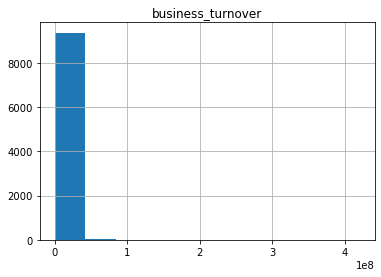

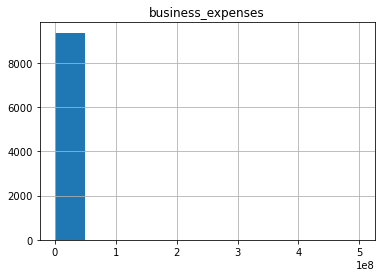

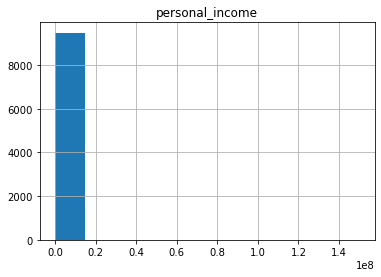

In [331]:
import matplotlib.pyplot as plt

money_cols = ['business_turnover', 'business_expenses', 'personal_income']

for col in money_cols:
    plt.figure()
    train_data[col].hist(bins=10)
    plt.title(col)
    plt.show()


#### feature engineering

In [332]:
def add_insurance_perception_features(df):

    df = df.copy()

    # Mapping dictionaries
    important_map = {
        "Yes": 1,
        "No": -1
    }

    doesnt_cover_map = {
        "No": 1,
        "Yes": -1
    }

    cannot_afford_map = {
        "No": 1,
        "Yes": -1
    }

    dont_insure_map = {
        "No": 1,
        "Yes": -1
    }

    # Apply mappings
    df['ins_important_score'] = df['perception_insurance_important'].map(important_map)
    df['ins_trust_score'] = df['perception_insurance_doesnt_cover_losses'].map(doesnt_cover_map)
    df['ins_afford_score'] = df['perception_cannot_afford_insurance'].map(cannot_afford_map)
    df['ins_access_score'] = df['perception_insurance_companies_dont_insure_businesses_like_yours'].map(dont_insure_map)

    # Replace NaN (e.g., Don't know / Refused) with 0
    score_cols = [
        'ins_important_score',
        'ins_trust_score',
        'ins_afford_score',
        'ins_access_score'
    ]

    df[score_cols] = df[score_cols].fillna(0)

    # Create final perception index
    df['insurance_perception_index'] = df[score_cols].mean(axis=1)

    return df


In [333]:
train_data = add_insurance_perception_features(train_data)
test_data = add_insurance_perception_features(test_data)


In [334]:
cols_to_drop = [
    'perception_insurance_important',
    'perception_insurance_doesnt_cover_losses',
    'perception_cannot_afford_insurance',
    'perception_insurance_companies_dont_insure_businesses_like_yours'
]

train_data.drop(columns=cols_to_drop)
test_data.drop(columns=cols_to_drop)

,ID,country,owner_age,attitude_stable_business_environment,attitude_worried_shutdown,compliance_income_tax,personal_income,business_expenses,business_turnover,motor_vehicle_insurance,...,motivation_make_more_money,uses_friends_family_savings,uses_informal_lender,business_age_total_months,business_age_total_years,ins_important_score,ins_trust_score,ins_afford_score,ins_access_score,insurance_perception_index
0,ID_5EGLKX,zimbabwe,50.0,No,No,No,100.0,3600.0,7200.0,Never had,...,NaN,NaN,NaN,188.0,15.666667,1.0,1.0,-1.0,1.0,0.50
1,ID_4AI7RE,lesotho,36.0,Yes,Yes,No,900.0,400.0,900.0,Never had,...,Yes,Used to have but don't have now,Used to have but don't have now,60.0,5.000000,0.0,-1.0,-1.0,0.0,-0.50
2,ID_V9OB3M,lesotho,25.0,Don’t know or N/A,No,No,5250.0,350.0,1000.0,Never had,...,No,Never had,Used to have but don't have now,120.0,10.000000,0.0,0.0,0.0,0.0,0.00
3,ID_6OI9DI,malawi,25.0,Don’t know or N/A,Yes,No,485000.0,10000.0,20000.0,NaN,...,Yes,Have now,Never had,48.0,4.000000,1.0,1.0,-1.0,0.0,0.25
4,ID_H2TN8B,lesotho,47.0,No,Yes,No,97.0,500.0,2000.0,Never had,...,Yes,Used to have but don't have now,Used to have but don't have now,12.0,1.000000,0.0,0.0,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2400,ID_FX7XJZ,eswatini,29.0,Yes,Yes,No,600.0,1700.0,2000.0,Never had,...,NaN,Never had,Never had,71.0,5.916667,1.0,1.0,-1.0,1.0,0.50
2401,ID_XAL1LX,malawi,20.0,Don’t know or N/A,Don’t know or N/A,No,30000.0,20000.0,25000.0,NaN,...,Yes,NaN,NaN,4.0,0.333333,0.0,0.0,0.0,0.0,0.00
2402,ID_UHBP0F,zimbabwe,26.0,Yes,Yes,No,3888.0,NaN,NaN,Never had,...,NaN,NaN,NaN,48.0,4.000000,1.0,-1.0,-1.0,1.0,0.00
2403,ID_GKIKR2,eswatini,63.0,No,No,Yes,3500.0,1700.0,1200.0,Never had,...,NaN,Never had,Never had,148.0,12.333333,1.0,-1.0,-1.0,0.0,-0.25


In [335]:


train_data['profit_margin'] = (
    (train_data['business_turnover'] - train_data['business_expenses']) /
    (train_data['business_turnover'] + 1e-6)
)

test_data['profit_margin'] = (
    (test_data['business_turnover'] - test_data['business_expenses']) /
    (test_data['business_turnover'] + 1e-6)
)


In [336]:

train_data['net_business_income'] = train_data['business_turnover'] - (train_data['business_expenses'] + 1e-6)
test_data['net_business_income'] = test_data['business_turnover'] - (test_data['business_expenses'] + 1e-6)


## Risk perception score

In [337]:
def create_risk_perception_score(df):

    risk_vars = {}

    # 1. Worried about shutdown
    risk_vars['worried_shutdown'] = (df['attitude_worried_shutdown'] == 'Yes').astype(int)

    # 2. Cash flow problems
    risk_vars['cashflow_problem'] = (df['current_problem_cash_flow'] == 'Yes').astype(int)

    # 3. Problem sourcing money
    risk_vars['sourcing_problem'] = (df['problem_sourcing_money'] == 'Yes').astype(int)

    # 4. Future theft risk
    risk_vars['future_theft_risk'] = (df['future_risk_theft_stock'] == 'Yes').astype(int)

    # 5. Insurance doesn’t cover losses
    risk_vars['insurance_not_cover'] = (df['perception_insurance_doesnt_cover_losses'] == 'Yes').astype(int)

    # 6. Insurance companies don’t insure businesses like yours
    risk_vars['insurance_exclusion'] = (
        df['perception_insurance_companies_dont_insure_businesses_like_yours'] == 'Yes'
    ).astype(int)

    # 7. Cannot afford insurance
    risk_vars['cannot_afford_insurance'] = (
        df['perception_cannot_afford_insurance'] == 'Yes'
    ).astype(int)

    risk_df = pd.DataFrame(risk_vars)

    # Final Risk Score = sum of all risk signals
    df['risk_perception_score'] = risk_df.sum(axis=1)

    df['risk_perception_score_norm'] = df['risk_perception_score'] / 7


    return df


In [338]:
train_data = create_risk_perception_score(train_data)
test_data = create_risk_perception_score(test_data)


In [339]:
def create_digital_banking_flag(df):

    digital_products = pd.DataFrame({
        'mobile_money': (df['has_mobile_money'] == 'Have now').astype(int),
        'internet_banking': (df['has_internet_banking'] == 'Have now').astype(int),
        'debit_card': (df['has_debit_card'] == 'Have now').astype(int),
        'credit_card': (df['has_credit_card'] == 'Have now').astype(int),
        'loan_account': (df['has_loan_account'] == 'Have now').astype(int),
    })

    df['digital_banking_score'] = digital_products.sum(axis=1)

    # Flag: at least 1 digital product
    df['digital_banking_flag'] = (df['digital_banking_score'] > 0).astype(int)

    return df


In [340]:
train_data = create_digital_banking_flag(train_data)
test_data = create_digital_banking_flag(test_data)


In [341]:
# Define x and y 
X = train_data.drop(columns=['Target', 'ID'])
y = train_data['Target']



X_test = test_data.drop(columns=['ID'])

In [342]:
def change_object_to_cat(df):
  # changes objects columns to category and returns dataframe and list

  df = df.copy()
  list_str_obj_cols = df.columns[df.dtypes == "object"].tolist()
  for str_obj_col in list_str_obj_cols:
      df[str_obj_col] = df[str_obj_col].astype("category")

  return df,list_str_obj_cols
X, cat_list = change_object_to_cat(X)

X

,country,owner_age,attitude_stable_business_environment,attitude_worried_shutdown,compliance_income_tax,perception_insurance_doesnt_cover_losses,perception_cannot_afford_insurance,personal_income,business_expenses,business_turnover,...,ins_trust_score,ins_afford_score,ins_access_score,insurance_perception_index,profit_margin,net_business_income,risk_perception_score,risk_perception_score_norm,digital_banking_score,digital_banking_flag
0,eswatini,63,Yes,No,No,No,Yes,3000.0,6000.0,7000.0,...,1.0,-1.0,-1.0,0.0,0.142857,1.000000e+03,4,0.571429,1,1
1,zimbabwe,39,No,Yes,Yes,No,Yes,NaN,NaN,NaN,...,1.0,-1.0,1.0,0.5,NaN,NaN,2,0.285714,1,1
2,malawi,34,Don’t know or N/A,No,No,Don't know,Yes,30000.0,6000.0,13000.0,...,0.0,-1.0,0.0,0.0,0.538462,7.000000e+03,4,0.571429,0,0
3,malawi,28,Yes,No,No,No,No,180000.0,60000.0,30000.0,...,1.0,1.0,1.0,1.0,-1.000000,-3.000000e+04,0,0.000000,1,1
4,zimbabwe,43,Yes,No,No,Yes,Yes,50.0,2400.0,1800.0,...,-1.0,-1.0,-1.0,-0.5,-0.333333,-6.000000e+02,3,0.428571,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9613,lesotho,31,Yes,No,No,Don't know,Don't know,2000.0,800.0,500.0,...,0.0,0.0,0.0,0.0,-0.600000,-3.000000e+02,1,0.142857,1,1
9614,malawi,64,Don’t know or N/A,Don’t know or N/A,Yes,No,No,10000000.0,5000000.0,200000000.0,...,1.0,1.0,1.0,1.0,0.975000,1.950000e+08,2,0.285714,2,1
9615,zimbabwe,43,Yes,No,No,Yes,No,450.0,NaN,NaN,...,-1.0,1.0,1.0,0.5,NaN,NaN,1,0.142857,1,1
9616,zimbabwe,38,Yes,Yes,No,No,Yes,2000.0,NaN,NaN,...,1.0,-1.0,1.0,0.0,NaN,NaN,2,0.285714,0,0


In [343]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9618 entries, 0 to 9617
Data columns (total 48 columns):
 #   Column                                                            Non-Null Count  Dtype   
---  ------                                                            --------------  -----   
 0   country                                                           9618 non-null   category
 1   owner_age                                                         9618 non-null   int64   
 2   attitude_stable_business_environment                              9616 non-null   category
 3   attitude_worried_shutdown                                         9616 non-null   category
 4   compliance_income_tax                                             9614 non-null   category
 5   perception_insurance_doesnt_cover_losses                          9613 non-null   category
 6   perception_cannot_afford_insurance                                9613 non-null   category
 7   personal_income         

In [344]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=train_data[['country', 'Target']]
)

In [345]:

# 1. Identify your columns
num_cols = X_train.select_dtypes(include=['float64']).columns
cat_cols = X_train.select_dtypes(include=['object','category']).columns

# 2. Define the Numerical Transformer
# Median is safer for financial data; Scaling is essential for most models
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 3. Define the Categorical Transformer
# handle_unknown='ignore' prevents the model from crashing if the test set 
# has a category the training set never saw.
# Updated for older Scikit-Learn versions
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # Change made here
])

# 4. Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ]
)

# 5. Fit and Transform X_train
# We "fit" only on train to avoid data leakage
# Fit and transform
# Fit and transform
X_train_array = preprocessor.fit_transform(X_train)
X_val_array = preprocessor.transform(X_val)

# Manually build feature names
num_features = num_cols.tolist()

ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_features = ohe.get_feature_names_out(cat_cols)

feature_names = num_features + list(cat_features)

# Convert to DataFrame
X_train_processed = pd.DataFrame(
    X_train_array,
    columns=feature_names,
    index=X_train.index
)

X_val_processed = pd.DataFrame(
    X_val_array,
    columns=feature_names,
    index=X_val.index
)




print(f"Original shape: {X_train.shape}")
print(f"Processed shape: {X_train_processed.shape}")

Original shape: (7694, 48)
Processed shape: (7694, 162)


In [346]:
X_train_processed

,personal_income,business_expenses,business_turnover,business_age_total_months,business_age_total_years,ins_important_score,ins_trust_score,ins_afford_score,ins_access_score,insurance_perception_index,...,uses_friends_family_savings_Never had,uses_friends_family_savings_Used to have but don't have now,uses_friends_family_savings_Used to have but don’t have now,uses_informal_lender_Don't know,uses_informal_lender_Don’t know (Do not show),uses_informal_lender_Have now,uses_informal_lender_Missing,uses_informal_lender_Never had,uses_informal_lender_Used to have but don't have now,uses_informal_lender_Used to have but don’t have now
5111,-0.095297,-0.070392,-0.144878,-0.513816,-0.513816,-1.731746,0.962263,-0.711384,-1.572387,-1.096517,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3681,-0.096729,-0.071794,-0.146329,-0.227531,-0.227531,-1.731746,0.962263,1.715300,1.079508,0.814378,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5087,-0.096727,-0.071741,-0.146133,-0.667969,-0.667969,0.875701,-0.232838,-0.711384,-0.246439,-0.141069,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2608,-0.096698,-0.071798,-0.146393,-0.535837,-0.535837,-0.428023,0.962263,-0.711384,-0.246439,-0.141069,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7554,-0.093142,-0.071072,-0.144813,-0.667969,-0.667969,0.875701,0.962263,1.715300,1.079508,1.769825,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5158,-0.095657,-0.059979,-0.124657,-0.260564,-0.260564,0.875701,-1.427939,-0.711384,-1.572387,-1.096517,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1863,-0.096626,-0.071807,-0.146389,-0.535837,-0.535837,-0.428023,-0.232838,0.501958,-0.246439,-0.141069,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7278,-0.096662,-0.071670,-0.146120,-0.767067,-0.767067,0.875701,0.962263,-0.711384,1.079508,0.814378,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5116,-0.095297,-0.071664,-0.146251,-0.535837,-0.535837,-0.428023,0.962263,-0.711384,-0.246439,-0.141069,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [347]:


# Correlation with turnover
corr_years = X_train_processed['business_age_total_years'].corr(X_train_processed['business_turnover'])


print("Correlation (years) vs turnover:", corr_years)


Correlation (years) vs turnover: 0.038319207866934095


In [348]:



# 1. Update the Pipeline with Random Forest

rf_model_pipe = Pipeline(steps=[

    ('preprocessor', preprocessor),

    ('classifier', RandomForestClassifier(

        n_estimators=200,

        max_depth= 10,  # Limiting depth to prevent overfitting the small 'High' class

        class_weight='balanced_subsample',

        random_state=42,

        n_jobs=-1

    ))

])

In [349]:

# The pipeline will now find the strings 'savings_assets_index', etc.
rf_model_pipe.fit(X, y)

# 3. Evaluate using the same DataFrame
rf_preds = rf_model_pipe.predict(X)
rf_probs = rf_model_pipe.predict_proba(X)

print("--- Random Forest Classification Report ---")
print(classification_report(y, rf_preds))

--- Random Forest Classification Report ---
              precision    recall  f1-score   support

        High       0.85      0.95      0.90       470
         Low       0.94      0.89      0.92      6280
      Medium       0.78      0.86      0.82      2868

    accuracy                           0.89      9618
   macro avg       0.86      0.90      0.88      9618
weighted avg       0.89      0.89      0.89      9618



In [350]:
predictions = rf_model_pipe.predict(X_test)
predictions

array(['Low', 'Medium', 'Low', ..., 'Medium', 'Medium', 'Low'],
      dtype=object)

In [351]:
p = pd.DataFrame({
    "ID": test_data["ID"],
    "Target": predictions
})


p.head(20)

,ID,Target
0,ID_5EGLKX,Low
1,ID_4AI7RE,Medium
2,ID_V9OB3M,Low
3,ID_6OI9DI,Low
4,ID_H2TN8B,Low
5,ID_U8T7ZQ,Medium
6,ID_QQJ3A1,Low
7,ID_F5S4JD,Low
8,ID_CY2C11,Medium
9,ID_63XVFI,Low


In [352]:
p.to_csv("sub2.csv", index=False)

In [353]:
y_train.value_counts(normalize=True)


Low       0.652976
Medium    0.298024
High      0.048999
Name: Target, dtype: float64

In [354]:

# -------------------------
# 4. Train LightGBM
# -------------------------
model = LGBMClassifier(
    n_estimators=2000,
    learning_rate=0.03,
    random_state=42
)

model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='multi_logloss',
    callbacks=[lgb.early_stopping(100)]
)


# -------------------------
# 5. Predictions
# -------------------------
y_pred = model.predict(X_val)

# -------------------------
# 6. Evaluation
# -------------------------
print("Classification Report:")
print(classification_report(y_val, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

# -------------------------
# 7. Extract top 50 most important features
# -------------------------
feature_importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance": model.feature_importances_
})

top50 = feature_importances.sort_values("importance", ascending=False).head(50)
print("\nTop 50 Features:")
print(top50)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2020
[LightGBM] [Info] Number of data points in the train set: 7694, number of used features: 48
[LightGBM] [Info] Start training from score -3.015951
[LightGBM] [Info] Start training from score -0.426214
[LightGBM] [Info] Start training from score -1.210580
Training until validation scores don't improve for 100 rounds


Early stopping, best iteration is:
[201]	valid_0's multi_logloss: 0.305314
Classification Report:
              precision    recall  f1-score   support

        High       0.90      0.59      0.71        93
         Low       0.88      0.98      0.93      1256
      Medium       0.86      0.70      0.78       575

    accuracy                           0.88      1924
   macro avg       0.88      0.76      0.81      1924
weighted avg       0.88      0.88      0.87      1924


Confusion Matrix:
[[  55    3   35]
 [   0 1226   30]
 [   6  164  405]]

Top 50 Features:
                                              feature  importance
42                                      profit_margin        1665
7                                     personal_income        1571
43                                net_business_income        1338
8                                   business_expenses        1337
1                                           owner_age        1278
35                          busin

In [369]:
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# -------------------------
# Identify numeric and categorical columns
# -------------------------
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns

# -------------------------
# Numeric pipeline
# -------------------------
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# -------------------------
# Categorical pipeline
# -------------------------
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# -------------------------
# Combine pipelines
# -------------------------
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

# -------------------------
# Full pipeline with SMOTE and LightGBM
# -------------------------
model_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LGBMClassifier(
        n_estimators=2000,
        learning_rate=0.03,
        random_state=42
    ))
])

# -------------------------
# Train the model
# -------------------------
model_pipeline.fit(X_train, y_train)

# -------------------------
# Predictions
# -------------------------
y_pred = model_pipeline.predict(X_val)

# -------------------------
# Evaluation
# -------------------------
print("Classification Report:")
print(classification_report(y_val, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

# -------------------------
# Feature importances
# -------------------------
# Extracting feature names after preprocessing
preprocessed_features = model_pipeline.named_steps['preprocessor'].get_feature_names_out()
feature_importances = pd.DataFrame({
    "feature": preprocessed_features,
    "importance": model_pipeline.named_steps['classifier'].feature_importances_
})

top50 = feature_importances.sort_values("importance", ascending=False).head(50)
print("\nTop 50 Features:")
print(top50)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26185
[LightGBM] [Info] Number of data points in the train set: 15072, number of used features: 151
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Classification Report:
              precision    recall  f1-score   support

        High       0.84      0.61      0.71        93
         Low       0.89      0.95      0.92      1256
      Medium       0.82      0.74      0.78       575

    accuracy                           0.87      1924
   macro avg       0.85      0.77      0.80      1924
weighted avg       0.87      0.87      0.87      1924


Confusion Matrix:
[[  57    3   33]
 [   0 1194   62]
 [  11  139  425]]

Top 

In [355]:
importance = pd.Series(model.feature_importances_, index=X_train.columns)
importance.sort_values(ascending=False)


profit_margin                                                       1665
personal_income                                                     1571
net_business_income                                                 1338
business_expenses                                                   1337
owner_age                                                           1278
business_age_total_months                                           1248
digital_banking_score                                                992
business_turnover                                                    959
has_insurance                                                        607
funeral_insurance                                                    497
has_loan_account                                                     429
risk_perception_score                                                407
has_credit_card                                                      385
uses_friends_family_savings                        

In [356]:
for col in X_train.select_dtypes(include='category').columns:
    X_test[col] = X_test[col].astype('category')
    X_test[col] = X_test[col].cat.set_categories(
        X_train[col].cat.categories
    )



In [357]:
predictions1 = model.predict(X_test)
predictions1

array(['Low', 'Low', 'Low', ..., 'Medium', 'Medium', 'Low'], dtype=object)

In [358]:
p1 = pd.DataFrame({
    "ID": test_data["ID"],
    "Target": predictions1
})


p1.head(20)



,ID,Target
0,ID_5EGLKX,Low
1,ID_4AI7RE,Low
2,ID_V9OB3M,Low
3,ID_6OI9DI,Low
4,ID_H2TN8B,Low
5,ID_U8T7ZQ,Medium
6,ID_QQJ3A1,Low
7,ID_F5S4JD,Low
8,ID_CY2C11,Medium
9,ID_63XVFI,Low


In [359]:
p1.to_csv("sub3.csv", index=False)

In [360]:


# Identify columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns

# Numeric pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

# Full pipeline
model_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(
        n_estimators=500,
        learning_rate=0.03,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softprob',
        eval_metric='mlogloss',
        random_state=42
    ))
])



In [361]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

model_pipeline.fit(X_train, y_train_enc)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['owner_age', 'personal_income', 'business_expenses',
       'business_turnover', 'business_age_total_months',
       'business_age_total_years', 'ins_important_score', 'ins_trust_score',
       'ins_afford_scor...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.03,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=500,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', predictor=None, ...))])

In [362]:
# Predict encoded labels
y_pred_enc = model_pipeline.predict(X_val)

# Convert back to original labels
y_pred = le.inverse_transform(y_pred_enc)

In [363]:

print("Classification Report:")
print(classification_report(y_val, y_pred))

Classification Report:
              precision    recall  f1-score   support

        High       0.89      0.61      0.73        93
         Low       0.90      0.96      0.93      1256
      Medium       0.83      0.77      0.80       575

    accuracy                           0.88      1924
   macro avg       0.88      0.78      0.82      1924
weighted avg       0.88      0.88      0.88      1924



In [364]:
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

Confusion Matrix:
[[  57    3   33]
 [   0 1200   56]
 [   7  126  442]]


In [365]:
from sklearn.metrics import f1_score

print("Macro F1:", f1_score(y_val, y_pred, average='macro'))
print("Weighted F1:", f1_score(y_val, y_pred, average='weighted'))

Macro F1: 0.8179415304115746
Weighted F1: 0.880054539972096


In [366]:
# Recreate X_test cleanly
X_test = test_data.drop(columns=['ID'])

# Predict
y_pred_enc = model_pipeline.predict(X_test)
y_pred = le.inverse_transform(y_pred_enc)

# Check lengths
print(len(y_pred), len(test_data))

# Create submission
submission = pd.DataFrame({
    "ID": test_data["ID"].values,
    "Target": y_pred
})

submission.head()

2405 2405


,ID,Target
0,ID_5EGLKX,Low
1,ID_4AI7RE,Low
2,ID_V9OB3M,Low
3,ID_6OI9DI,Medium
4,ID_H2TN8B,Low


In [367]:
y_pred

array(['Low', 'Low', 'Low', ..., 'Medium', 'Medium', 'Low'], dtype=object)

In [368]:
submission.to_csv("sub5.csv", index=False)

## Handling oversampling to improve XGBoost performance